In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tqdm
import os

from many_stop_words import get_stop_words
from nltk.corpus import stopwords
from nltk.tokenize import sent_tokenize
from nltk.tokenize import word_tokenize

from glob import glob

In [2]:
base_dir = '../data/dane_slowa_klucze/'

In [4]:
glob(base_dir + '*')

['../data/dane_slowa_klucze/interia',
 '../data/dane_slowa_klucze/natemat',
 '../data/dane_slowa_klucze/onet',
 '../data/dane_slowa_klucze/wp',
 '../data/dane_slowa_klucze/fronda',
 '../data/dane_slowa_klucze/gw',
 '../data/dane_slowa_klucze/rp_arch',
 '../data/dane_slowa_klucze/rp']

In [5]:
summary = pd.read_csv(base_dir + 'interia/GATT/art.csv', sep='\t')

In [6]:
summary.head()

,id,data,url,słowa klucze,nazwa pliku,liczba komentarzy
0,1,2016-12-23,http://biznes.interia.pl/makroekonomia/news/sa...,interia_1.txt,GATT (1),118
1,2,2017-05-26,http://biznes.interia.pl/makroekonomia/news/wi...,interia_2.txt,"CETA (1), GATT (1), WTO (12)",11
2,3,2018-07-12,https://biznes.interia.pl/makroekonomia/news/d...,interia_3.txt,GATT (4),10
3,4,2014-06-30,https://biznes.interia.pl/wiadomosci/news/na-s...,interia_4.txt,"GATT (1), WTO (7)",32
4,5,2016-08-12,https://fakty.interia.pl/news-wto-potwierdza-z...,interia_5.txt,"GATT (1), WTO (5)",59


In [7]:
glob(base_dir + '/interia/CEFTA/art/*')

['../data/dane_slowa_klucze//interia/CEFTA/art/interia_8.txt',
 '../data/dane_slowa_klucze//interia/CEFTA/art/interia_5.txt',
 '../data/dane_slowa_klucze//interia/CEFTA/art/interia_4.txt',
 '../data/dane_slowa_klucze//interia/CEFTA/art/interia_6.txt',
 '../data/dane_slowa_klucze//interia/CEFTA/art/interia_7.txt',
 '../data/dane_slowa_klucze//interia/CEFTA/art/interia_3.txt',
 '../data/dane_slowa_klucze//interia/CEFTA/art/interia_2.txt',
 '../data/dane_slowa_klucze//interia/CEFTA/art/interia_1.txt']

In [8]:
article = pd.read_csv(base_dir + 'interia/CEFTA/art/interia_1.txt', sep='\n\r', header=None)

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  """Entry point for launching an IPython kernel.


In [9]:
article.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 80 entries, 0 to 79
Data columns (total 1 columns):
0    80 non-null object
dtypes: object(1)
memory usage: 720.0+ bytes


In [10]:
article.head(), article.tail()

(                                                   0
 0                              Aktywność gospodarcza
 1  W I kwartale 2000 roku produkt krajowy brutto ...
 2  Zmniejsza się tempo wzrostu popytu krajowego z...
 3  W II półroczu 1999 roku popyt krajowy zwiększy...
 4  Zwolnienie tempa wzrostu spożycia wynika z niż...,
                                                     0
 75  - rozwój sieci prywatnego i publicznego pośred...
 76  - przyspieszenie prac nad projektem ustawy o k...
 77                             4. Zmiany prawa pracy:
 78  - ograniczenie możliwości łączenia pobierania ...
 79  Sprawdź:  zobacz tanie noclegi w Poznaniu na e...)

## Check if last sentence value
Seems like some might be just an advertisement

In [12]:
[
    print(pd.read_csv(path, sep='\t', header=None).values[-1], pd.read_csv(path, sep='\t', header=None).shape)
    for path in sorted(glob(base_dir + 'interia/GATT/art/*'))
]

['Sprawdź:  hale całoroczne najlepszy wybór, https://sii.pl/oddzialy/krakow/, Reserved promocje - Zrabatowani'] (29, 1)
['Sprawdź:  Hosting od Kei.pl'] (17, 1)
['Sprawdź:  hale całoroczne najlepszy wybór, https://sii.pl/oddzialy/krakow/, Reserved promocje - Zrabatowani'] (16, 1)
['Dlatego trudno wskazać jedną przyczynę obecnego polskiego eksportowego boomu. Można go tłumaczyć przymusem w sytuacji, w której w kraju na początku lat 90. oraz 10 lat później gwałtownie zaczął słabnąć popyt wewnętrzny. Doszły do tego korzystne wówczas zmiany w przeliczeniach walutowych (deprecjacja złotego), trwające do połowy 2004 r., oraz poprawa koniunktury światowej. Do rozkwitu przyczyniło się także wstąpienie Polski do Unii Europejskiej. Uprościło ono prowadzenie działalności gospodarczej przez rodzime firmy na wspólnym rynku, zniosło ograniczenia i limity, tak ważne np. w eksporcie towarów rolno-spożywczych.'] (13, 1)
['Sprawdź:  hale całoroczne najlepszy wybór, https://sii.pl/oddzialy/krakow/, Reserv

[None, None, None, None, None, None, None, None, None, None, None, None]

## Read articles from data

In [57]:
class ArticlesOrganizer:
    def __init__(self, base_dir):
        self.base_dir = base_dir
        self.articles_header = ['id', 'site', 'topic', 'file_name']
        self.list_of_sites = self.get_list_of_sites()
        self.list_of_topics = self.get_list_of_topics()
#         self.articles = self.get_articles()
        
    def get_list_of_sites(self):
        return [
            site 
            for site in sorted(os.listdir(self.base_dir)) if site != '.DS_Store'
        ]
    
    def get_list_of_topics(self):
        return sorted(os.listdir(self.base_dir + self.list_of_sites[0]))
    
    def get_articles(self):
        articles = [
            [site, topic, base_dir + site + '/' + topic + '/art/' + article] 
            for site in self.list_of_sites 
            for topic in self.list_of_topics
            for article in os.listdir(self.base_dir + site + '/' + topic + '/art/')
        ]
        
        for counter, article in enumerate(articles):
            article.insert(0, counter + 1) 
        articles.insert(0, self.articles_header)
        
        return np.asarray(articles)

In [58]:
organizer = ArticlesOrganizer(base_dir)

In [59]:
articles = organizer.get_articles()

In [60]:
articles

array([['id', 'site', 'topic', 'file_name'],
       ['1', 'fronda', 'CETA',
        '../data/dane_slowa_klucze/fronda/CETA/art/fronda_40.txt'],
       ['2', 'fronda', 'CETA',
        '../data/dane_slowa_klucze/fronda/CETA/art/fronda_41.txt'],
       ...,
       ['4135', 'wp', 'WTO',
        '../data/dane_slowa_klucze/wp/WTO/art/wp_122.html'],
       ['4136', 'wp', 'WTO',
        '../data/dane_slowa_klucze/wp/WTO/art/wp_14.html'],
       ['4137', 'wp', 'WTO',
        '../data/dane_slowa_klucze/wp/WTO/art/wp_43.html']], dtype='<U58')

In [61]:
data = pd.DataFrame(articles[1:], columns = articles[0])

In [62]:
data.head()

,id,site,topic,file_name
0,1,fronda,CETA,../data/dane_slowa_klucze/fronda/CETA/art/fron...
1,2,fronda,CETA,../data/dane_slowa_klucze/fronda/CETA/art/fron...
2,3,fronda,CETA,../data/dane_slowa_klucze/fronda/CETA/art/fron...
3,4,fronda,CETA,../data/dane_slowa_klucze/fronda/CETA/art/fron...
4,5,fronda,CETA,../data/dane_slowa_klucze/fronda/CETA/art/fron...


## Check articles from interia
Hint: They're already txt files

In [71]:
interia = data[(data.site == 'interia')]
interia.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 520 entries, 663 to 1182
Data columns (total 4 columns):
id           520 non-null object
site         520 non-null object
topic        520 non-null object
file_name    520 non-null object
dtypes: object(4)
memory usage: 20.3+ KB


In [80]:
df_interia = []
for filename in interia.file_name:
    try:
        df_interia.append(pd.read_csv(filename, sep='\n\r', header=None))
    except ParserError:
        continue

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  after removing the cwd from sys.path.


In [81]:
df_interia[0]

,0
0,Wicepremier i minister gospodarki Janusz Stein...
1,"""Chciałbym, jako minister gospodarki, aby zain..."
2,REKLAMA
3,"""Poziom sprzedaży na rynkach zewnętrznych jest..."
4,Strata netto Daewoo-FSO Motor SA wzrosła w 200...
5,Od początku roku do końca sierpnia Daewoo sprz...
6,Daewoo-FSO Motor SA ma zapas części do produkc...
7,We wtorek wstrzymanie dostaw części zmusiło sz...
8,Tymczasem prawdopodobnie już jutro wierzyciele...


## Compare two polish stopwords sets
* `many_stop_words.get_stop_words`
* `nltk.corpus.stopwords.words('polish')`

    For nltk stopwords, you need to put this file:
    [Polish stopwords](https://github.com/bieli/stopwords/blob/master/polish.stopwords.txt)
    
    Into your nltk library at:
    `nltk_data/corpora/stopwords/`

In [86]:
polish_stopwords = get_stop_words('pl')

In [85]:
polish_stopwords_nltk = list(stopwords.words('polish'))

In [87]:
len(polish_stopwords), len(polish_stopwords_nltk)

(274, 350)

# Stemming using pystempel

https://github.com/dzieciou/pystempel

In [88]:
from stempel import StempelStemmer

In [89]:
stemmer = StempelStemmer.polimorf()

Loading:  99%|█████████▉| 11303144/11368252 [00:11<00:00, 1145206.39bytes/s]

In [90]:
for word in df_interia[0].values[0][0].split():
    if len(word) > 2:
        print(word, '\t\t\t', stemmer.stem(word))

Wicepremier 			 Wicepremier
minister 			 minister
gospodarki 			 gospodarka
Janusz 			 Jazić
Steinhoff 			 Steinhoff
powiedział, 			 powiedział,
byłby 			 być
zadowolony, 			 zadowolony,
gdyby 			 gdybyć
zainteresowanie 			 zainteresowanie
fabryką 			 fabryka
Daewoo-FSO 			 Daewoo-FSO
Motor 			 Motor
Warszawie 			 Warszawa
wyraził 			 wyrazić
jeden 			 jeden
producentów 			 producent
koreańskich. 			 koreańskich.
Tymczasem 			 Tymczas
prawdopodobnie 			 prawdopodobnia
już 			 ć
jutro 			 jutro
wierzyciele 			 wierzyciel
Daewoo 			 Daewosić
Motor 			 Motor
Co. 			 Co.
przedstawią 			 przedstawić
rezultaty 			 rezultat
rozmów 			 rozmówić
General 			 General
Motors 			 Motors
(GM) 			 (GM)
sprawie 			 sprawa
sprzedaży 			 sprzedaż
południowokoreańskiego 			 południowokoreański
koncernu 			 koncern
Amerykanom. 			 Amerykanom.
Polsce 			 Polsce
jest 			 być
zapas 			 zapas
części 			 część
produkcji 			 produkcja
oraz 			 oraz
części 			 część
zamiennych 			 zamienny
serwisu, 			 serwisu,


Loading: 100%|██████████| 11368252/11368252 [00:30<00:00, 1145206.39bytes/s]

# Extraction summarization

In [101]:
def calculate_average_weight_for_article(sentence_weight) -> int:
    sum_values = 0
    
    for entry in sentence_weight:
        sum_values += sentence_weight[entry]

    average_weight = (sum_values / len(sentence_weight))

    return average_weight

In [102]:
def stem_sentence(sentence) -> str:
    stemmed_sentence = [
        stemmer.stem(word)
        for word in word_tokenize(sentence.lower()) if (word is not None) and (len(word) > 2)
    ]
    filtered_sentece = filter(None, stemmed_sentence)
    return " ".join(filtered_sentece)

In [103]:
def calculate_sentence_weight(sentences, frequency_table) -> dict:
    sentence_weight = dict()
    sent_index = 10
    
    for sentence in sentences:
        sentence_wordcount = len(word_tokenize(sentence))
        sentence_wordcount_without_stop_words = 0
        stemmed_sentence = stem_sentence(sentence)
        
        for word_weight in frequency_table:
            if word_weight in stemmed_sentence.lower():
                sentence_wordcount_without_stop_words += 1
                
                if sentence[:sent_index] in sentence_weight:
                    sentence_weight[sentence[:sent_index]] += frequency_table[word_weight]
                else:
                    sentence_weight[sentence[:sent_index]] = frequency_table[word_weight]
                    
        sentence_weight[sentence[:sent_index]] = sentence_weight[sentence[:sent_index]] \
            / sentence_wordcount_without_stop_words

    return sentence_weight

In [153]:
def create_dictionary_table(text) -> dict:
    stop_words = polish_stopwords
    words = word_tokenize(text)
    word_length_threshold = 3
    
    frequency_table = {}
    for word in words:
        if len(word) >= word_length_threshold:
            word = stemmer.stem(word)
        if word in stop_words or word is None:
            continue
        word = word.lower()
        if word in frequency_table:
            frequency_table[word] += 1
        else:
            frequency_table[word] = 1
            
    return frequency_table

In [132]:
import heapq

In [134]:
sentence_weight

{'Wicepremie': 3.380952380952381,
 'Tymczasem ': 4.2016,
 'A w Polsce': 3.3461538461538463,
 '"Chciałbym': 3.1818181818181817,
 'Zwróciłem ': 2.0625,
 'Zaintereso': 3.5,
 'Według nie': 3.75,
 'Steinhoff ': 2.769230769230769,
 '"Poziom sp': 1.8888888888888888,
 'Przecież D': 2.5,
 'Druga spra': 2.6470588235294117,
 'Strata net': 4.352941176470588,
 'Na straty ': 2.3333333333333335,
 'Od początk': 3.533333333333333,
 'Daewoo-FSO': 3.6538461538461537,
 '"Mamy zapa': 3.6666666666666665,
 'Na pewno w': 1.6666666666666667,
 'We wtorek ': 3.5,
 'Prawdopodo': 2.945945945945946,
 'Do GM będz': 4.5}

In [133]:
heapq.nlargest(5, sentence_weight)

['Zwróciłem ', 'Zaintereso', 'Wicepremie', 'Według nie', 'We wtorek ']

In [135]:
def get_article_summary(sentences, sentence_weight, percentage=.25):
    no_of_sentences_in_summary = int(len(sentences) * percentage)
    sentence_counter = 0
    article_summary = ''
    sent_index = 10
    sentences_in_summary = heapq.nlargest(no_of_sentences_in_summary, sentence_weight)
    for sentence in sentences:
        if sentence[:sent_index] in sentences_in_summary:
            article_summary += " " + sentence
            sentence_counter += 1

    return article_summary

In [106]:
def filter_short_sentences(sentences, threshold=30):
    return [sentence for sentence in sentences if len(sentence) > threshold]

In [150]:
def pipeline_article_summary(article, percentage=0.25):
    sentences = exctract_sentences_from_article(article=article)
    sentences = filter_short_sentences(sentences=sentences)
    selected_article = ' '.join(sentences)
    
    frequency_table = create_dictionary_table(selected_article.lower())
    sentence_weight = calculate_sentence_weight(sentences, frequency_table)
    
    threshold = calculate_average_weight_for_article(sentence_weight)
    article_summary = get_article_summary(sentences, sentence_weight, percentage=percentage)
    
    return article_summary

## Example summarization

In [113]:
def get_articles_from_df(dataframe):
    return [
        dataframe[i].values.squeeze()
        for i in range(len(dataframe))
    ]

In [114]:
articles = get_articles_from_df(df_interia)

In [115]:
def exctract_sentences_from_article(article):
    sentences = []
    for i, article in enumerate(article):
        sentences += sent_tokenize(article)
    return sentences

In [116]:
sentences = exctract_sentences_from_article(articles[0])
sentences

['Wicepremier i minister gospodarki Janusz Steinhoff powiedział, że byłby zadowolony, gdyby zainteresowanie fabryką Daewoo-FSO Motor SA w Warszawie wyraził jeden z producentów koreańskich.',
 'Tymczasem prawdopodobnie już jutro wierzyciele Daewoo Motor Co. przedstawią rezultaty rozmów z General Motors (GM) w sprawie sprzedaży południowokoreańskiego koncernu Amerykanom.',
 'A w Polsce jest zapas części do produkcji oraz części zamiennych do serwisu, a przestoje w koreańskich fabrykach koncernu nie będą miały wpływu na działanie polskiej spółki - poinformowała Krystyna Danilczyk, rzeczniczka Daewoo-FSO.',
 '"Chciałbym, jako minister gospodarki, aby zainteresowanie tą fabryką wyraził jeden z producentów koreańskich.',
 'Zwróciłem się nawet ze stosownym listem i zaproszeniem do rozmów" - powiedział minister gospodarki Janusz Steinhoff.',
 'Zainteresowania polskimi fabrykami Daewoo w Warszawie i Lublinie nie wyraził General Motors, który negocjuje kupno koreańskich aktywów Daewoo.',
 'Wedłu

(array([2., 1., 1., 1., 0., 2., 3., 2., 2., 2., 0., 2., 2., 0., 0., 2., 1.,
        0., 0., 0., 0., 0., 0., 0., 1.]),
 array([  7.  ,  21.64,  36.28,  50.92,  65.56,  80.2 ,  94.84, 109.48,
        124.12, 138.76, 153.4 , 168.04, 182.68, 197.32, 211.96, 226.6 ,
        241.24, 255.88, 270.52, 285.16, 299.8 , 314.44, 329.08, 343.72,
        358.36, 373.  ]),
 <a list of 25 Patch objects>)

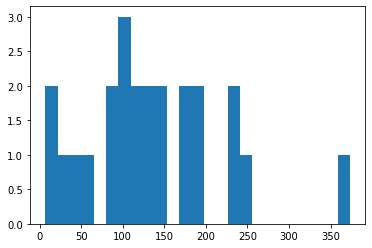

In [117]:
plt.hist([len(sent) for sent in sentences], bins=25)

In [118]:
sentences = filter_short_sentences(sentences)
article = ' '.join(sentences)

In [119]:
article

'Wicepremier i minister gospodarki Janusz Steinhoff powiedział, że byłby zadowolony, gdyby zainteresowanie fabryką Daewoo-FSO Motor SA w Warszawie wyraził jeden z producentów koreańskich. Tymczasem prawdopodobnie już jutro wierzyciele Daewoo Motor Co. przedstawią rezultaty rozmów z General Motors (GM) w sprawie sprzedaży południowokoreańskiego koncernu Amerykanom. A w Polsce jest zapas części do produkcji oraz części zamiennych do serwisu, a przestoje w koreańskich fabrykach koncernu nie będą miały wpływu na działanie polskiej spółki - poinformowała Krystyna Danilczyk, rzeczniczka Daewoo-FSO. "Chciałbym, jako minister gospodarki, aby zainteresowanie tą fabryką wyraził jeden z producentów koreańskich. Zwróciłem się nawet ze stosownym listem i zaproszeniem do rozmów" - powiedział minister gospodarki Janusz Steinhoff. Zainteresowania polskimi fabrykami Daewoo w Warszawie i Lublinie nie wyraził General Motors, który negocjuje kupno koreańskich aktywów Daewoo. Według nieoficjalnych informac

In [121]:
frequency_table = create_dictionary_table(article.lower())

In [122]:
frequency_table

{'wicepremier': 1,
 'minister': 3,
 'gospodarka': 3,
 'jazić': 2,
 'steinhoff': 4,
 'powiedzieć': 3,
 ',': 22,
 'zadowolony': 1,
 'gdybyć': 1,
 'zainteresowanie': 3,
 'fabryka': 7,
 'daewoo-fsojciec': 6,
 'motor': 10,
 'sa': 3,
 'warszawa': 3,
 'wyrazić': 3,
 'producent': 2,
 'koreański': 6,
 '.': 20,
 'tymczas': 2,
 'prawdopodobnia': 3,
 'ć': 2,
 'jutro': 2,
 'wierzyciel': 4,
 'daewosić': 11,
 'co.': 2,
 'przedstawić': 2,
 'rezultat': 2,
 'rozmówić': 3,
 'general': 3,
 'motors': 3,
 '(': 2,
 'gm': 4,
 ')': 2,
 'sprawa': 3,
 'sprzedaż': 4,
 'południowokoreański': 2,
 'koncern': 6,
 'amerykan': 2,
 'polsce': 2,
 'zapas': 3,
 'część': 9,
 'produkcja': 5,
 'zamienny': 3,
 'serwis': 3,
 'przestój': 2,
 'n': 4,
 'mieć': 3,
 'wpływ': 2,
 'działanie': 2,
 'polski': 2,
 'spółka': 3,
 '-': 5,
 'poinformować': 2,
 'krystyna': 2,
 'danilczyk': 2,
 'rzeczniczka': 2,
 '``': 3,
 'chcieć': 1,
 'tą': 1,
 'zwrócić': 1,
 'nawenie': 1,
 'ze': 2,
 'stosowny': 1,
 'list': 1,
 'zaproszenie': 1,
 "''": 3,
 '

In [124]:
sentence_weight = calculate_sentence_weight(sentences, frequency_table)

In [125]:
sentence_weight

{'Wicepremie': 3.380952380952381,
 'Tymczasem ': 4.2016,
 'A w Polsce': 3.3461538461538463,
 '"Chciałbym': 3.1818181818181817,
 'Zwróciłem ': 2.0625,
 'Zaintereso': 3.5,
 'Według nie': 3.75,
 'Steinhoff ': 2.769230769230769,
 '"Poziom sp': 1.8888888888888888,
 'Przecież D': 2.5,
 'Druga spra': 2.6470588235294117,
 'Strata net': 4.352941176470588,
 'Na straty ': 2.3333333333333335,
 'Od początk': 3.533333333333333,
 'Daewoo-FSO': 3.6538461538461537,
 '"Mamy zapa': 3.6666666666666665,
 'Na pewno w': 1.6666666666666667,
 'We wtorek ': 3.5,
 'Prawdopodo': 2.945945945945946,
 'Do GM będz': 4.5}

In [127]:
threshold = calculate_average_weight_for_article(sentence_weight)
threshold

3.169046808341808

Text(0, 0.5, 'Number of sentences')

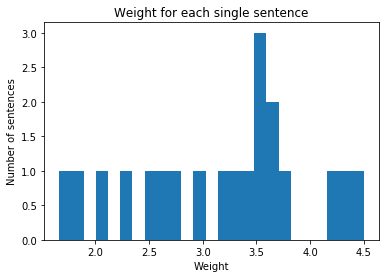

In [128]:
plt.hist(sentence_weight.values(), bins=25)
plt.title('Weight for each single sentence')
plt.xlabel('Weight')
plt.ylabel('Number of sentences')

In [144]:
article_summary = get_article_summary(sentences, sentence_weight, percentage=0.25)

In [145]:
article_summary

' Wicepremier i minister gospodarki Janusz Steinhoff powiedział, że byłby zadowolony, gdyby zainteresowanie fabryką Daewoo-FSO Motor SA w Warszawie wyraził jeden z producentów koreańskich. Zwróciłem się nawet ze stosownym listem i zaproszeniem do rozmów" - powiedział minister gospodarki Janusz Steinhoff. Zainteresowania polskimi fabrykami Daewoo w Warszawie i Lublinie nie wyraził General Motors, który negocjuje kupno koreańskich aktywów Daewoo. Według nieoficjalnych informacji zainteresowany Daewoo-FSO może być koreańskiego rywal Daewoo Motor, koncern motoryzacyjny Hyundai. We wtorek wstrzymanie dostaw części zmusiło szefów Daewoo Motor do wstrzymania produkcji niektórych modeli aut w zakładach koncernu w Bupiong i Kunsan.'

In [147]:
print('Summary length', len(article_summary))
print('Original length', len(article))
print('Percentage', len(article_summary) / len(article))

Summary length 731
Original length 3227
Percentage 0.22652618531143476


# Pipeline

#### Original

In [173]:
" ".join(articles[2])

'O 8 groszy więcej płacimy od dziś za litr benzyny i oleju napędowego z Rafinerii Gdańskiej. To kolejny producent podnoszący ceny - od wczoraj droższe są produkty Polskiego Koncernu Naftowego ORLEN. Benzyny i olej napędowy z Płocka podrożały również o 8 groszy. Szansą za zahamowanie podwyżek cen paliw będzie zniesienie od jutra cen na importowane paliwa. Na sprowadzane z krajów Unii Europejskiej, EFTA, CEFTA, Litwy, Estonii, Wysp Owczych i Turcji będzie obowiązywać zerowa stawka. O obniżce rząd zdecydował w ubiegłym tygodniu. Krok ten ma pomóc w walce z inflacją. REKLAMA Teraz - w przypadku benzyny - stawka celna wynosi 3 proc., a oleju napędowego 4 proc. Decyzja rządu zaledwie o kilkadziesiąt dni przyspiesza redukcję stawek, która i tak - zgodnie z umową z Unią Europejską - zaczęłaby obowiązywać 1 stycznia 2001 roku. Zdaniem ekspertów, polscy kierowcy niewiele zyskają na obniżce ceł, bo może to doprowadzić jedynie do spadku cen paliw na stacjach o około 4 grosze na litrze.'

#### Summarized

In [174]:
pipeline_article_summary(article=articles[2])

' To kolejny producent podnoszący ceny - od wczoraj droższe są produkty Polskiego Koncernu Naftowego ORLEN. Zdaniem ekspertów, polscy kierowcy niewiele zyskają na obniżce ceł, bo może to doprowadzić jedynie do spadku cen paliw na stacjach o około 4 grosze na litrze.'

## Summarize all interia articles

In [168]:
for i, article in enumerate(articles):
    print('Summary for text', i)
    print('=' * 97)
    summary = pipeline_article_summary(article=article)
    print(summary)
    print('=' * 30, 'Percentage of original text :', np.round(len(summary) / len(" ".join(article)) * 100), '%', '=' * 30)

Summary for text 0
 Wicepremier i minister gospodarki Janusz Steinhoff powiedział, że byłby zadowolony, gdyby zainteresowanie fabryką Daewoo-FSO Motor SA w Warszawie wyraził jeden z producentów koreańskich. Zwróciłem się nawet ze stosownym listem i zaproszeniem do rozmów" - powiedział minister gospodarki Janusz Steinhoff. Zainteresowania polskimi fabrykami Daewoo w Warszawie i Lublinie nie wyraził General Motors, który negocjuje kupno koreańskich aktywów Daewoo. Według nieoficjalnych informacji zainteresowany Daewoo-FSO może być koreańskiego rywal Daewoo Motor, koncern motoryzacyjny Hyundai. We wtorek wstrzymanie dostaw części zmusiło szefów Daewoo Motor do wstrzymania produkcji niektórych modeli aut w zakładach koncernu w Bupiong i Kunsan.
============================== Percentage of original text : 22.0 % ==============================
Summary for text 1
 Według niego, rząd obstaje też przy stanowisku, żeby wszelkie nowe dopłaty bezpośrednie dla rolników w poszerzonej Unii były równe

 Władysław Kosiniak-Kamysz /Jakub Porzycki /Agencja FORUM W jego ocenie na podpisaniu umowy o wolnym handlu z Kanadą straci też polskie rolnictwo, "a najbardziej straci zdrowie i życie naszych mieszkańców". W ten sposób odniósł się do także do opracowywanej przez Polskie Stronnictwo Ludowe "wiejsko-miejskiej" polityki. Wynegocjowane w 2014 r. Całościowe Gospodarcze i Handlowe Porozumienie UE-Kanada (CETA) proponuje zniesienie niemal wszystkich ceł i barier pozataryfowych oraz liberalizację handlu usługami między Unią Europejską a Kanadą. Zdaniem urzędników unijnych sprzeciw Belgów dyktowany jest względami politycznymi. Zaznaczyła, że ratyfikacja umowy wymaga zgody parlamentów narodowych, w Polsce - zgody 2/3 Sejmu.
============================== Percentage of original text : 18.0 % ==============================
Summary for text 9
 Umowa CETA osłabi unijną zasadę ostrożności, jedno z największych osiągnięć wspólnoty europejskiej - alarmują organizacje obywatelskie. W interesie arbitrów

 Za ratyfikacją opowiedziało się 408 z prawie 700 europosłów. Za ratyfikacją opowiedziało się 408 z prawie 700 europosłów, którzy wzięli udział w głosowaniu. Wielu deputowanych podczas debaty poprzedzającej głosowanie podkreślało, że w czasie gdy Stany Zjednoczone z nowym prezydentem na czele zamykają się na świat, Europa musi pokazać, że idzie w zupełnie innym kierunku. Większość jej zapisów, dotyczących ceł, dzięki zgodzie PE będzie jednak stosowana tymczasowo jeszcze przed zakończeniem całego procesu ratyfikacyjnego. W środę Parlament Europejski przegłosował również stanowisko w sprawie kształtu reformy unijnego systemu pozwoleń na emisję CO2 (ETS). Zmiany mają służyć temu, by UE doszła do wyznaczonego na 2030 rok 40-procentowego celu redukcji emisji gazów cieplarnianych. rocznie, jednak wiodąca w tej sprawie komisja środowiska PE zdecydowała się na jego podniesienie do 2,4 proc.
============================== Percentage of original text : 29.0 % ==============================
Summa

 Wiemy, że potrzebna jest wciąż jakaś praca i w pełni to szanujemy" - powiedział na środowej konferencji prasowej w Brukseli szef Rady Europejskiej. Umowa CETA, podobnie jak negocjowana umowa o partnerstwie handlowym i inwestycyjnym ze Stanami Zjednoczonymi, czyli TTIP, budzą wielkie kontrowersje i protesty niektórych środowisk, obawiających się osłabienia praw pracowniczych, standardów ochrony środowiska i bezpieczeństwa żywności czy zwiększenia wpływów wielkich korporacji. Wynegocjowane w 2014 r. Całościowe Gospodarcze i Handlowe Porozumienie UE-Kanada (CETA) proponuje zniesienie niemal wszystkich ceł i barier pozataryfowych oraz liberalizację handlu usługami między Unią Europejską a Kanadą.
============================== Percentage of original text : 38.0 % ==============================
Summary for text 38
 Wczoraj Belgia zgodziła się na porozumienie, a ambasadorowie krajów członkowskich zaakceptowali deklarację z jej postulatami, która zostanie dołączona do umowy. ilustracyjne /WO

 Środa, 16 listopada 2016 (14:11) Zobacz, jak UE dotychczas handlowała z Kanadą. Wszystko, co musisz wiedzieć o handlu między Europą i Kanadą /©123RF/PICSEL całego eksportu UE poza wspólny rynek. wszystkich towarów przywiezionych z całego świata do UE. Wśród nich znajdują się wzbudzające najwięcej obaw artykuły spożywcze. łącznego importu towarów z Kanady. Z państw członkowskich najbardziej ożywiony handel z Kanadą prowadzą Niemcy i Wielka Brytania, z tą małą różnicą, że Niemcy mają dodatni bilans handlowy, natomiast Brytyjczycy są na minusie. Wśród państw Wspólnoty Polska jest na ósmym miejscu pod względem wielkości eksportu i czternastym importerem z czwartym najlepszym bilansem handlowym z Kanadą. po stronie eksportu i o 21 proc. łącznej wartości eksportu usług. wszystkich usług importowanych spoza UE.
============================== Percentage of original text : 18.0 % ==============================
Summary for text 50
 Szef ludowców pytany, czy czytał porozumienie Unia-Kanada, któr

 Zwrócił uwagę, że rolnictwo kanadyjskie jest inne niż polskie m.in. pod względem jakości surowców, jak i podejścia przemysłu przetwórczego do surowców rolnych. w zakresie informowania o składzie, w tym także o obecności GMO. Żeby Kanada mogła cokolwiek wprowadzić na polski rynek, musi spełnić wymogi europejskie" - powiedział. Wyjaśnił, że wymogi UE są jednymi z najbardziej rygorystycznych na świecie. Zdaniem dyrektora PFPŻ, umowa CETA może być szansą dla polskich producentów żywności, gdyż europejska żywność, w tym polska bez GMO, uważana jest na świecie za żywność premium. wszelkich barier dostępu do rynku, co oznacza, że jeżeli Polska radzi sobie ze sprzedażą żywności w wielu krajach Unii, to da sobie także radę w Kanadzie. Wynegocjowane w 2014 r. Całościowe Gospodarcze i Handlowe Porozumienie UE-Kanada (CETA) proponuje zniesienie niemal wszystkich ceł i barier pozataryfowych oraz liberalizację handlu usługami między Unią Europejską a Kanadą. Według fundacji Akcja Demokracja podpisa

 Wielkie koncerny szkodzą naszemu zdrowiu, niszczą środowisko i wykorzystują niewolniczą pracę. To będzie trochę jak bajka o złym wilku. W 1984 r. firma Bayer odkryła, że jej lek na hemofilię może zarażać pacjentów wirusem HIV. W sumie w krajach Trzeciego Świata Bayer sprzedał ponad 100 tys. opakowań leku już po tym, jak przestał rozprowadzać go w Europie i w USA. Wskutek stosowania tego środka ponad 10 tys. chorych zaraziło się wirusem HIV w samych Stanach i na Starym Kontynencie. W oświadczeniu mogliśmy przeczytać, że przy jego sprzedaży koncern postępował "odpowiedzialnie, etycznie i humanitarnie". W latach 1996-2000 amerykańskie firmy wyeksportowały do krajów rozwijających się 500 tys. ton pestycydów, w większości zakazanych w USA, gdyż wywołują nowotwory. koncern American Cyanamid Co. sprzedał Kostarykańczykom pestycyd o nazwie Counter, nie informując, że praca z tym środkiem wymaga specjalnej odzieży ochronnej. To system, w którym przyszło nam dziś funkcjonować. Takim klasycznym 

============================== Percentage of original text : 16.0 % ==============================
Summary for text 81
 Z Quebec City Alicja Minda (PAP)
============================== Percentage of original text : 4.0 % ==============================
Summary for text 82
 Premier Walonii Paul Magnette poinformował, że przekaże szefowi belgijskiego MSZ, że ten nie będzie mógł podpisać traktatu ratyfikacyjnego w imieniu całego kraju.
============================== Percentage of original text : 20.0 % ==============================
Summary for text 83
 Wniosek o wotum nieufności wobec ministra rolnictwa i rozwoju wsi Krzysztofa Jurgiela złożyli we wtorek w Sejmie posłowie PSL. Zarzucają ministrowi "szkodliwą politykę na polskiej wsi, ukazującą bezczynność i bezradność". Zarzuty, jakie stawiają  dotyczą m.in. zaniedbań w obszarze rozwoju wsi i polskiego rolnictwa. Zdaniem wnioskodawców, Jurgiel dopuścił się też zaniedbań w związku ze sprawą "niedziałającego systemu ubezpieczeń rolnych". We 

 Po utrąceniu przez szefa Rady Europejskiej Donalda Tuska planu Theresy May rośnie ryzyko zerwania rozmów z Brukselą - informuje "Rzeczpospolita". Publicznie chodziło o 'uspokojenie' atmosfery rozmów" - czytamy w "Rz". Sprawa stała się też wodą na młyn zwolenników twardego brexitu, zwłaszcza przed rozpoczynającym się 30 września w Birmingham zjazdem torysów.
============================== Percentage of original text : 20.0 % ==============================
Summary for text 94
 umowy CETA rozwija się dynamicznie. W świetle tych wydarzeń pewne jest już, że umowa, która miała zostać podpisana dzisiaj, musi jeszcze poczekać. Zaledwie kilka godzin po odwołaniu spotkania z kanadyjskimi przedstawicielami, rząd Belgii ogłosił, że jednak udało się wypracować porozumienie z Walonią. W powszechnej opinii odwołanie czwartkowego szczytu nie oznacza fiaska samej umowy CETA, jest to jednak kompromitacja dla strony unijnej, która do samego końca obstawała przy pierwotnym terminie szczytu - zauważyła w 

 We wtorek, 6 marca, zapadła przełomowa decyzja Trybunału Sprawiedliwości Unii Europejskiej. Ów zapis wyłącza spod mechanizmu kontroli sądowej prawa Unii spory mogące dotyczyć stosowania lub wykładni tego prawa" - czytamy w komunikacie trybunału. chroniąca środowisko naturalne, albo jakakolwiek decyzja władz, narusza jego interesy, może on dzięki ISDS pozwać państwo do zwoływanego ad hoc międzynarodowego sądu polubownego, z pominięciem sądownictwa w danym kraju. W ten sposób Polska została w 2003 r. pozwana przez holenderski koncern Eureko za wycofanie się z prywatyzacji PZU. W ramach ugody polski rząd zgodził się zapłacić Holendrom aż dziewięć miliardów złotych odszkodowania. Tym bardziej, że owe polubowne sądy większość spraw rozstrzygały na korzyść inwestorów. Wyrok trybunału dzięki Słowacji Wtorkowy wyrok Trybunału Sprawiedliwości UE, określany już mianem historycznego, to wynik sporu Słowacji z holenderskim koncernem Achmea, specjalizującym się w ubezpieczeniach zdrowotnych. W 200

 Z prof. Leokadią Oręziak rozmawialiśmy o zagrożeniach wynikających z umowy CETA (Comprehensive Economic and Trade Agreement) - porozumienia o wolnym handlu między Unią Europejską a Kanadą. Zanim jednak przejdziemy do poszczególnych aspektów tej umowy, chciałem zapytać, czy zdaniem pani profesor wolny handel między państwami to jest co do zasady dobry kierunek? Wolny handel jest dobry, jeśli uwzględnia interesy słabszego partnera. Taka jest istota wolnego handlu, że wygrywa silniejszy. Wolny handel wprowadzany jest tutaj na zasadzie: wygrywa ten, kto jest silniejszy, a słabszy po prostu będzie musiał ucierpieć. Umowy nowego typu nie tylko znoszą cła i ograniczenia ilościowe, ale przede wszystkim uderzają w bariery wynikające z systemów prawnych krajów będących stronami umowy, bariery, które tworzą dodatkowe koszty i zmniejszają zyski korporacji handlujących przez Atlantyk. Tylko korporacje zyskają na umowie CETA? To jednak bardzo wątpliwa korzyść. W umowie CETA obowiązuje wzajemne uzna

 Waloński premier Paul Magnette oświadczył, że region nie dostał wystarczających gwarancji, które rozwiałyby obawy dotyczące umowy. W przypadku tych dwóch krajów problemem jest wciąż utrzymywany przez Kanadę wymóg wizowy wobec obywateli rumuńskich i bułgarskich. W Polsce swój sprzeciw wyraziła część partii opozycyjnych, ale też Komisja Krajowa NSZZ "Solidarność". W Luksemburgu przed budynkiem, w którym spotykali się ministrowie, przeciw zawarciu umowy protestowało we wtorek około 100 działaczy różnych organizacji. Wówczas arbitraż miał chronić inwestora w razie niekorzystnych dla niego decyzji rządów państw, w których demokratyczne instytucje dopiero się tworzyły. Z kolei wiceminister rozwoju podkreślał, że Polska chce, by nasz region miał swojego reprezentanta w nowym sądzie inwestycyjnym. Wynegocjowane w 2014 r. Całościowe Gospodarcze i Handlowe Porozumienie UE-Kanada (CETA) proponuje zniesienie niemal wszystkich ceł i barier pozataryfowych oraz liberalizację handlu usługami między U

 To on będzie dziś towarzyszył premier Beacie Szydło na rozpoczynającym się w Brukseli unijnym szczycie. Wiceminister mówi, że Polska chce niezależności przy podejmowaniu decyzji: o ochronie pracy, zdrowia i określaniu standardów żywności, która do nas trafi. Wynegocjowane w 2014 r. Całościowe Gospodarcze i Handlowe Porozumienie UE-Kanada (CETA) proponuje zniesienie niemal wszystkich ceł i barier pozataryfowych oraz liberalizację handlu usługami między Unią Europejską a Kanadą. Zobacz również nasz raport specjalny: INTERIA prześwietla CETA
============================== Percentage of original text : 25.0 % ==============================
Summary for text 134
 Zniesie ona ok. 99 procent ceł we wzajemnym handlu, większość barier pozataryfowych i zliberalizuje handel usługami. Zgodziła się dopiero, gdy uzgodniła z rządem federalnym deklarację, która odpowiada na jej zastrzeżenia i rozwiewa obawy dotyczące między innymi sytuacji w rolnictwie, czy międzynarodowego arbitrażu, który ma rozstrz

 o kwestie ratyfikacji, podkreślał, że sprzeciw jednego państwa w odniesieniu do części inwestycyjnej umowy między Kanadą a Unią Europejską powinien spowodować, że nie wejdzie ona w życie. Tutaj państwa członkowskie, parlamenty narodowe nie muszą ratyfikować tej części. Wątpliwość dotyczy części inwestycyjnej, w której znajdują się najbardziej kontrowersyjne zapisy (...) - podkreślił w rozmowie z Interią dr Adam Kirpsza. W związku z czym ta częśc nie powinna wejść w życie - tłumaczył. Zachęcamy do obejrzenia transmisji:
============================== Percentage of original text : 20.0 % ==============================
Summary for text 148
 W znacznym stopniu stały się odpowiedzialne za wywołanie kryzysu w 2007 r., problemów na tle wzajemnych rozliczeń handlowych, wreszcie - wywołanie wojen walutowych. Ułatwiają bowiem poprawę konkurencyjności via niedozwolona dewaluacja waluty, a więc kosztem innych aktorów gospodarki światowej, m.in. takich, jak Brazylia, która w rezultacie zmuszona je

 sporu o rosyjskie embarga na import świń, mięsa wieprzowego i niektórych produktów wieprzowych z Unii - podała KE. W związku z utrzymywaniem embarga przez Rosję i brakiem rezultatów w negocjacjach między Moskwą a Komisją Europejską, 8 kwietnia Unia Europejska wniosła do WTO sprawę przeciwko Rosji dotyczącą embarga na wieprzowinę z Unii. Zgodnie z zasadami tej organizacji, UE i Rosja miały 60 dni na konsultacje i ew. znalezienie rozwiązania sprawy na tej drodze. W związku z brakiem rezultatów tych rozmów UE postanowiła zwrócić się do WTO o ustanowienie panelu, który orzeknie w sprawie zgodności z prawem rosyjskiego embarga. rolnictwa Dacian Ciolos podkreślił, że rosyjski zakaz nałożony na wieprzowinę z UE już odcisnął poważne piętno na tym sektorze w UE i wymusił zastosowanie wsparcia kryzysowego. W rozmowie z PAP dodał, że na kilkadziesiąt tysięcy przesyłek, jakie trafiają na rosyjski rynek z Polski mogą zdarzyć się jakieś przekroczenia norm. ton złej jakości jabłek z Polski. całego e

 Wojciech Jaruzelski ogłaszający wprowadzenie stanu wojennego /AFP W jakim stanie była gospodarki PRL przed wprowadzeniem stanu wojennego? W gospodarkach działających w systemach niedemokratycznych przywódcy "kupują" poparcie społeczeństwa dopiero po objęciu władzy, a nie przed wyborami, jak ma to miejsce w krajach demokratycznych. W latach 1971-1974 przychody ludności rosły w wysokim tempie 14 procent rocznie. Wzrastała również stopa oszczędności. Wówczas dynamika tych trzech wskaźników ulega zmniejszeniu. W dużej mierze miało swoje przyczyny w okresie rządów Gierka. na spłatę zakupów licencji w ramach tak zwanej koncepcji samospłaty poprzez eksport towarów. W połowie lat siedemdziesiątych PRL wpadł w tzw. Władze stanęły przed dylematem, czy wybijać stada podstawowe i przejściowo utrzymać podaż mięsa na rynku, czy jednak zaryzykować sprowadzanie pasz. W sytuacji wprowadzenia takich sankcji gospodarczych spada wiarygodność kredytowa. W 1981 r. PRL była bankrutem, choć oczywiście był to

 Zakład w kanadyjskiej Oshawie, który ma zostać zamknięty /AFP Zakład w Oshawie na wschód od Toronto to nie tylko 2500 pracowników, którzy do końca 2018 r. będą pracować przy montażu samochodów. osób, bo każde miejsce pracy w fabryce GM tworzy dodatkowo 9 innych miejsc pracy: od zatrudnionych u producentów części do pracowników barów i restauracji w Oshawie. dolarów kanadyjskich 25 billboardów z napisem "Welcome to Ontario, open for business" (witamy w Ontario, otwarte dla biznesu). Związkowcy z Oshawy zapowiedzieli, że będą ostro walczyć o przedłużenie funkcjonowania swojej fabryki. ceł na import samochodów GM z Meksyku. Z kolei dziennik "The Toronto Star" podawał, że do zakładów w Oshawie odnosił się prezydent USA Donald Trump podczas negocjacji nowej NAFTA. miejsc pracy, zamykając siedem zakładów: cztery w USA, jeden z Kanadzie i dwa poza Ameryką Płn.
============================== Percentage of original text : 19.0 % ==============================
Summary for text 169
 Wcześniej ag

 Od północy w piątek trwa cisza przedwyborcza. Spójrz na nagrodzone wcześniej hasła: Ukryta kamera załatwi blagiera - hasło Andrzeja Szeniawskiego dla Mariana Krzaklewskiego Zamiast się wałęsać, poprzyj mnie - Wałęsa - hasło Marcina Petrykowskiego dla Lecha Wałęsy Wniosek jest oczywisty - by prać brudy, należy być czystym - hasło Pawła Dylika dla Aleksandra Kwaśniewskiego Wymaga wiele trudu pranie cudzego brudu - hasło Pawła Kołodziejskiego dla Mariana Krzaklewskiego Wykształcenie nie piwo - nie musi być pełne - hasło Agi Starmach dla Aleksandra Kwaśniewskiego Owczym pędem do prezydentury - hasło Marka Szczepańskiego dla Aleksandra Kwaśniewskiego Uśmiechnij się - jutro będzie Lepper! Prawdziwy Blok dla Polski - hasło Łukasza Kujawskiego dla Andrzeja Leppera Pomysł jest prosty - kara chłosty! Polska cała głosuje na generała! Z Olkiem i Lechem źle się czujesz?
============================== Percentage of original text : 23.0 % ==============================
Summary for text 183
 wynosi 3

 Wojna zastępcza już się toczy w Syrii. W tej chwili Assad prowadzi zabójcze rajdy pod osłoną rosyjskiego lotnictwa. Unia Europejska, jako podmiot prawa międzynarodowego i aktor stosunków międzynarodowych, jest w tym regionie nieobecna. Skrytykował to minister spraw zagranicznych Austrii, mówiąc, że dopóki imigranci będą mieli wrażenie, że w końcu i tak dotrą do Niemiec, dopóty będziemy mieć do czynienia z kolejnymi falami migrantów. Trzeba pomagać krajom, z których pochodzą uchodźcy. W orędziu o stanie Unii Juncker mówił, że Bruksela powinna wypracować europejską strategię dla Syrii, by pomóc odbudować pokojowe państwo syryjskie. Unia Europejska, jako podmiot prawa międzynarodowego i aktor stosunków międzynarodowych, jest w tym regionie nieobecna. koalicji "chcących i zdolnych", "willing and able". W takim razie co Juncker miał na myśli? Z Paryża, Berlina i Waszyngtonu słyszeliśmy jednak, że Rosja nie jest częścią problemu, ale częścią rozwiązania. Z Syrii mają już dziś wpływ na wscho

 W najbliższy wtorek podczas szczytu Rady UE państwa członkowskie zdecydują, czy umowa zostanie podpisana. ustami wiceministra rozwoju Radosława Domagalskiego - pozytywnie wyraża się o porozumieniu, zwolennikiem dealu Unia Europejska - Kanada jest też wicepremier Mateusz Morawiecki, ale oficjalnego stanowiska gabinet Beaty Szydło dotąd opinii publicznej nie przedstawił. umowy, zabrakło konsultacji społecznych na szeroką skalę. W efekcie społeczeństwa niewiele wiedzą na temat samego porozumienia, a także szans i zagrożeń, jakie za sobą niesie. zapisów CETA już się zakończyły. Unijni urzędnicy zaznaczają jednak, że CETA i TTIP podlegają odrębnym negocjacjom z dwoma różnymi partnerami. Wielkość rynku i jego dynamika są różne. Zwolennicy porozumienia CETA do plusów wskazanych przez Komisję Europejską wynikających z zacieśnienia współpracy z Kanadą dodają zniesienie ceł, a także otwarcie rynku usług i likwidację barier w dostępie do zamówień publicznych. W ich ocenie CETA przyniesie korzyśc

 W Brukseli znany jest z tego, że prawie z każdym serdecznie żartuje, wymienia uściski czy pocałunki w policzek. Unia odpowiedziała cłami na niektóre amerykańskie produkty. Trump od miesięcy grozi wprowadzeniem ceł na europejskie samochody, co uderzyłoby głównie w niemiecki przemysł motoryzacyjny. handlu Cecilia Malmstroem, która będzie towarzyszyć Junckerowi w podróży. Zamiast tego chętnie miesza on politykę handlową z polityką obronną i bezpieczeństwa. We wspomnianym wywiadzie dla CBS Trump mówił o Europie, że "w kwestii handlu naprawdę nas oszukali. Wiele z tych krajów jest także w NATO i nie płaci swoich rachunków" - mówił. Zdaniem Cecilii Malmstroem tych dwóch spraw nie powinno się łączyć. Unia Europejska jest w końcu największym partnerem handlowym USA i najważniejszym rynkiem eksportowym dla amerykańskich firm. Unia podpisała właśnie umowę o wolnym handlu z Japonią, podobne porozumienie z Kanadą czeka na ratyfikację. Trwają negocjacje z krajami Ameryki Łacińskiej i z Chinami. Wo

 Według nich, rokowania w ostatnim czasie znacząco przyspieszyły i osiągnięto "znaczący postęp" we współpracy regulacyjnej. Zapowiedzieli, że do lipca powinien być gotowy ujednolicony tekst większości umowy, a do uzgodnienia pozostaną tylko kwestie najtrudniejsze. W drugiej połowie roku, po przerwie wakacyjnej, negocjatorzy chcą wejść w ostatnią fazę rozmów. Według KE i USA TTIP ma wykraczać poza zwykłą umowę o wolnym handlu. W trakcie obecnej rundy strony omawiały unijną ofertę dotyczącą zmian w międzynarodowym systemie rozwiązywania sporów między inwestorem a państwem. z powodu braku możliwości apelacji osłabiają pozycję rządów. klauzuli ISDS) przedstawiła w listopadzie zeszłego roku unijna komisarz ds. stworzenie stałej listy arbitrów czy wprowadzenie możliwości apelacji. generalnego Konfederacji Lewiatan /Informacja prasowa daje możliwość, by otwierając własne rynki wzmocnić współpracę i dotychczasowe podstawy gospodarcze i biznesowe. Umowa między Stanami Zjednoczonymi i Europą na 

 Zresztą prezydent Francois Hollande od dłuższego czasu sceptycznie wypowiadał się na temat TTIP. Teraz oznajmił, że nie ma co utrzymywać dłużej iluzji. Warto też zwrócić uwagę, że i w Stanach Zjednoczonych pojawiła się presja, by nie przystępować do kolejnych umów o wolnym handlu. Zwłaszcza po trzech latach negocjacji. To jeszcze raz - czym jest TTIP? amerykańskie firmy muszą przygotowywać na europejski rynek produkty spełniające europejskie normy. Umowa TTIP budzi ogromne kontrowersje i niepokój w społeczeństwach Unii Europejskiej. Zarzuca się, że będzie ona służyła wyłącznie korporacjom, a nie obywatelom, że poskutkuje utratą 600 tys. miejsc pracy i obniżeniem standardów bezpieczeństwa produktów spożywczych czy kosmetycznych, a także pozbawi państwa suwerenności - w ramach mechanizmu ISDS (inwestor-przeciw-państwu) korporacje będą mogły pozywać kraje do trybunałów arbitrażowych. Tutaj trzeba być bardzo ostrożnym, ponieważ umowa CETA nie jest czymś innym i dokładnie z tych samych pow

 Waszyngton nie rezygnuje z przekonywania Brukseli do modyfikacji stanowiska. Wieloletnie spory, a nawet wojny handlowe (USA również wprowadzały zakaz importu wołowiny z Europy) oraz postępowania przed WTO doprowadziły do tego, że w 2009 r. UE zgodziła się ustanowić bezcłowy kontyngent w wysokości 20 tys. ton rocznie, jednak tylko na mięso ze zwierząt, którym nie podawano hormonów wzrostu. w skwaśniałym mleku) może usuwać ślady wykorzystywania hormonów. W 2013 r. tuż przed rozpoczęciem negocjacji ws. Według ekologów i stowarzyszeń rolników niechętnych GMO zmiany są groźne dla środowiska. uprawy i wprowadzania do obrotu roślin modyfikowanych genetycznie są poważnym problemem, który należałoby rozwiązać w ramach rokowań umowy o wolnym handlu. W USA żywność i pasze z GMO są bardzo rozpowszechnione. W czasie gdy unijne przepisy były zaostrzane tendencja w USA była zupełnie inna. W 2013 r. amerykański Senat odrzucił projekt ustawy, która miała dawać konsumentom możliwość świadomego wyboru z

 Wejście w finalną fazę negocjacji powinno oznaczać, że wszystkie rozdziały są już przygotowane - po przedstawieniu propozycji z obu stron powstał skonsolidowany tekst z nawiasami, w których zostawia się miejsce na ustalenia na szczeblu politycznym. w kwestii energii (zależy na tym Polsce), współpracy regulacyjnej w konkretnych sektorach (m.in. Ważnym przełomem było ustalenie wspólnego katalogu produktów, które nie będą objęte cłami. Większość z obniżek stawek celnych wejdzie w życie wraz z wdrożeniem porozumienia, w przypadku niektórych produktów potrzebne będą jednak dodatkowe okresy przejściowe. Z raportu Komisji wynika, że problemem pozostaje dostęp europejskich firm do amerykańskiego rynku zamówień publicznych. W tej chwili UE jest dużo bardziej otwarta niż USA. dostawy wody, kanalizacja, szpitale). W raporcie KE podkreślono, że obie strony negocjacji zgodziły się, by do lata tego roku przedstawione zostały propozycje zapisów we wszystkich obszarach, a w większości z nich przeprow

 W tym tygodniu w Nowym Jorku, rozpoczęła się kolejna dziewiąta już runda negocjacyjna. Zapisy projektu umowy o transatlantyckim partnerstwie handlowo-inwestycyjnym (TTIP) między USA a UE powinny być znane jeszcze w tym roku - ocenił szef MSZ Grzegorz Schetyna. Zdaniem przemawiającego na konferencji "Transatlantyckie partnerstwo w dziedzinie handlu i inwestycji", zorganizowanej przez PTE, dyrektora fundacji charytatywnej "War on Want" Johna Hilarego, TTIP nie jest zwykłym układem handlowym, lecz "umową nowej generacji", ponieważ poprzednie umowy zawierane z USA dążyły przede wszystkim do zniesienia barier celnych. Zwrócił też uwagę, że to nie tylko amerykańskie korporacje dążą do zniesienia barier w Europie. Z powodu tego, że liczyła na takie zyski, a państwo Polskie za pomocą swoich organów regulacyjnych podjęła decyzję, która ich zdaniem tych zysków ich pozbawiła - powiedział Wojtalik. Zdaniem prof. Leokadii Oręziak ze Szkoły Głównej Handlowej, korzyści z podpisania umowy TTIP są bar

 Z nieoficjalnych informacji, które podawał wcześniej Reuters wynika, że UE miała zaoferować USA zniesienie 96 proc. taryf importowych, zachowując ochronę taryfową tylko w przypadku niewielu "wrażliwych" produktów, takich jak wołowina, wieprzowina i drób. Zdaniem Synowiec, USA i UE różnią się m.in. w kwestiach taryf na produkty rolne. W czasie kolejnej, piątej rundy negocjacji, która zaplanowana jest na maj, ma się rozpocząć konstruowanie tekstu porozumienia. Zdecydowanie większe korzyści dla obu gospodarek przyniesie likwidacja barier, różnych utrudnień, spełniania dodatkowych wymogów, jakich oczekuje się od handlujących towarami z UE i USA. produktów będących w międzynarodowym handlu. idei TTIP, ich udział w światowym handlu wynosił odpowiednio 21 i 17 proc. W czwartek w Ministerstwie Gospodarki odbyły się konsultacje z organizacjami pozarządowymi ws. negocjowanego od ubiegłego roku przez Unię Europejską i Stany Zjednoczone transatlantyckiego partnerstwa handlowo-inwestycyjnego (TTIP

 ochrony inwestycji między Polską a 12 państwami UE nie będzie też miało negatywnych skutków gospodarczych czy społecznych - podkreślono. Wypowiadanie dwustronnych umów o wzajemnym popieraniu i ochronie inwestycji zawieranych pomiędzy krajami Unii Europejskiej (Intra-UE BITs, ang. Większość z tych umów została zawarta przed kolejnymi rozszerzeniami Unii w latach 2004, 2007 i 2013, kiedy jedna lub obie strony umowy nie były jeszcze członkami Wspólnoty. W związku z obowiązywaniem nadrzędnych według Komisji Europejskiej przepisów dotyczących transgranicznych porozumień inwestycyjnych państwa członkowskie były, począwszy od 2006 roku, wzywane do stopniowego rozwiązywania swoich umów, mimo to w Unii wciąż funkcjonuje ich ok. 200. Z drugiej strony nie wiadomo czy umowy uda się rozwiązać za porozumieniem stron, jak deklarowano w przypadku Danii, Rumunii oraz Czech, czy Polska wypowie je jednostronnie, jak z Portugalią. Warto tu zaznaczyć, że wypowiadanie dwustronnych umów o wzajemnym popieran

 amerykańskie firmy muszą przygotowywać na europejski rynek produkty spełniające europejskie normy. regulacje dotyczące bezpieczeństwa produktów, ochrony konsumenta czy środowiska naturalnego. Z opublikowanych przez ekonomistów wyliczeń wynika natomiast, że znacznie szybszym skutkiem będzie... utrata 600 tys. dzięki niższym kosztom energii oraz niższej ochronie pracowników (Stany Zjednoczone nie ratyfikowały kluczowych konwencji Międzynarodowej Organizacji Pracy). Znacznie większa konkurencja na rynku Unii ze strony towarów amerykańskich oznacza presję na obniżanie płac i uelastycznianie zasad zatrudniania. Tak, dobrze czytacie: jeszcze więcej śmieciówek i praca za głodowe stawki. Trzeba też podkreślić, że zakładana liberalizacja dostępu dla towarów ze Stanów Zjednoczonych do unijnego, a w rezultacie też do polskiego rynku, silnie ograniczy skuteczność planowanej przez rząd aktywnej polityki przemysłowej. to były spotkania z lobbystami działającymi na rzecz wielkiego biznesu, a tylko 5

 Zaczynamy rozmawiać o szczegółach. Wiemy oczywiście dobrze, że jest pewnie niepokój w sprawie GMO. Trzeci sektor, który Mull uznaje za potencjalnie skomplikowany w negocjacjach, to energetyka - ceny energii w USA są znacznie niższe niż w Europie. W ramach TTIP wyeliminowane mają zostać również często sprzeczne przepisy, co ma doprowadzić do zmniejszenia kosztów dla producentów i klientów. Umowa handlowa obejmie jedną trzecią światowego handlu, 52 proc. dotyczące rozwiązywania sporów w gospodarce. W Stanach Zjednoczonych 98 proc. takich problemów rozwiązuje się w drodze mediacji, a tylko 2 proc. W Polsce jest odwrotnie - mówił. Wzmocni nie tylko relacje transatlantyckie, ale i pozycję UE i USA w świecie - podkreśliła wiceminister spraw zagranicznych Katarzyna Kacperczyk. Wiceszefowa polskiej dyplomacji wskazała, iż negocjowane porozumienie będzie dodatkowym impulsem dla zwiększenia wymiany handlowej pomiędzy Polską a USA (rekordowa suma ponad 9 mld w 2013 r.), a także rozwoju współprac

 W tym tygodniu na sesji plenarnej w Strasburgu, gdzie odbywała się debata europosłów z udziałem Karela de Guchta, komisarza ds. handlu odpowiedzialnego za negocjacje, posłowie ponownie nawoływali do większej przejrzystości procesu. W UE mamy ponad 1300 substancji zakazanych, a w Stanach tylko 12 na poziomie federalnym, podobnie jest z etykietami, unijne zawierają więcej informacji ważnych dla klientów UE. jeśli produkt zawiera jeden z 26 alergenów musi to być wyszczególnione na etykiecie, ale nie w USA. W USA koncept bezpieczeństwa żywności oparty jest na wystarczającej pewności braku szkodliwości, przenosząc odpowiedzialność na producenta. W USA, by pozbyć się na końcowym etapie produkcji patogenów używa się chlorowania, podczas gdy od europejskich wymaga się przestrzegania zasad higieny na każdym etapie. ze względu na niebezpieczeństwa jakie w sobie kryje i brak przejrzystości. Zainicjowała ona Europejską Inicjatywę Obywatelską (możliwość nadana obywatelom unijnym Traktatem z Lizbon

 Wśród głosów poparcia słychać tezę, że traktat będzie w sferze gospodarczej pełniejszą realizacją wolnorynkowych idei, a w warstwie geopolitycznej - wzmocnieniem euroatlantyckiego partnerstwa. Unia obawia się, że amerykańskie giganty, korzystające z taniej energii, wyeliminują firmy europejskie. Świadczy o tym zarówno mozolny przebieg negocjacji, jak i rosnące obawy różnych grup interesu. Traktat ma zmienić tysiące zapisów w różnego rodzaju regulacjach. Trudno się zatem spodziewać, że wszystkie zmiany będą dla wszystkich oznaczały wyłącznie korzyści. zagranicznej pomocy ekonomicznej węgierskiego MSZ. gazu zużywanego w poszczególnych krajach Europy Środkowej pochodzi z Rosji. Wciąż trwają spory, czy Transatlantyckie Partnerstwo obejmie swoim zakresem sektor finansowy. Umożliwia on bowiem korporacjom zaskarżanie do sądu arbitrażowego przepisów kraju, w którym działają. Teraz idzie w gruncie rzeczy o to, by doprowadzić do kompromisu, w którym kurczak byłby zdezynfekowany, a Europejczyk -

 UE i USA chcą zakończyć negocjacje ws. Według nich, rokowania w ostatnim czasie znacząco przyspieszyły i osiągnięto "znaczący postęp" we współpracy regulacyjnej. Zapowiedzieli, że do lipca powinien być gotowy ujednolicony tekst większości umowy, a do uzgodnienia pozostaną tylko kwestie najtrudniejsze. W drugiej połowie roku, po przerwie wakacyjnej, negocjatorzy chcą wejść w ostatnią fazę rozmów. Według KE i USA TTIP ma wykraczać poza zwykłą umowę o wolnym handlu. W trakcie obecnej rundy strony omawiały unijną ofertę dotyczącą zmian w międzynarodowym systemie rozwiązywania sporów między inwestorem a państwem. z powodu braku możliwości apelacji osłabiają pozycję rządów. klauzuli ISDS) przedstawiła w listopadzie zeszłego roku unijna komisarz ds. stworzenie stałej listy arbitrów czy wprowadzenie możliwości apelacji. daje możliwość, by otwierając własne rynki wzmocnić współpracę i dotychczasowe podstawy gospodarcze i biznesowe. Umowa między Stanami Zjednoczonymi i Europą na razie nie dział

 Wedle relacji, Trump powiedział Merkel, że jest "świetna", niemniej "długi należy spłacać". Tematy związane z Unią Europejską miały Trumpa nudzić.
============================== Percentage of original text : 14.0 % ==============================
Summary for text 308
 Wiceprzewodniczący Komisji Europejskiej Jyrki Katainen powiedział, że Unia Europejska może zamrozić prawo głosu Polski, jeśli nasz kraj nie zmieni polityki i nie zgodzi się przestrzegać zasady rządów prawa. Wiceprzewodniczący Komisji Europejskiej oznajmił też, że Unia ciągle widzi szanse ożywienia rozmów o porozumieniu handlowym TTIP ze Stanami Zjednoczonymi. Zwrócił uwagę, że amerykański prezydent Donald Trump atakował w trakcie kampanii wyborczej głównie umowy o wolnym handlu z krajami Azji i Ameryki Północnej, a nie TTIP.
============================== Percentage of original text : 35.0 % ==============================
Summary for text 309
 W przypadku podpisania umów nasze rodzime produkty prawdopodobnie zostaną w bar

 światowego PKB, odpowiadają za 33 proc. światowego handlu towarami (wartość towarów z eksportowanych przez UE do USA to 288 mld euro rocznie, importowanych z USA - 196 mld euro) i 42 proc. obrotu usługami (unijny eksport to 159 mld euro, import - 146 mld), ale wszystkie te odsetki zmniejszają się na rzecz państw rozwijających się. Według szacunków europejskiego think-tanku Centre for Economic Policy Research, TTIP powinno się przełożyć na wzrost unijnego PKB o 68-119 mld euro rocznie do 2027 r., co procentowo nie jest wielkością gigantyczną, bo w 2014 r. unijna gospodarka miała wartość nieco ponad 16 bln euro. Wzrost amerykańskiego PKB ma zaś sięgnąć 50-95 mld euro. wobec 1,6 bln), czyli te z naszej strony Atlantyku mają przed sobą większe potencjalne możliwości. W przypadku Stanów Zjednoczonych premierowa była umowa o wolnym handlu z Izraelem z 1985 r., choć głównym impulsem dla dalszych tego typu układów stało się Północnoamerykańskie Porozumienie o Wolnym Handlu (NAFTA), na mocy kt

 Wiceprezes Rady Ministrów spotka się z przedstawicielami rządu USA, aby rozmawiać o miliardowych dostawach gazu LNG do Polski. Wicepremier Mateusz Morawiecki w USA /PAP Wizytę wicepremiera Morawieckiego relacjonuje z Waszyngtonu dziennikarz Interii Bartosz Bednarz. USA to nasz kluczowy partner w NATO i relacjach transatlantyckich - zaznaczył na poczatek wizyty w USA Wiceprezes Rady Ministrów Mateusz Morawiecki. Wciąż nie wiemy jakie dokładnie scenariusze będą realizowane przez stronę amerykańską, chociażby dotyczące porozumienia transatlantyckiego TTIP czy polityki celnej. handlu Wilburem Rossem mogą mieć przełomowe znaczenie w relacjach gospodarczych polsko-amerykańskich. Wciąż jednak, od strony gospodarczej nie wykorzystujemy w pełni możliwego potencjału. eksportu ogółem) oraz 15. w polskim imporcie (blisko 1,8 proc. pomysłu zastosowania specjalnych opłat dla tych krajów-importerów, które mają ogromną nadwyżkę handlową na rachunku bieżącym. energii, z którym omawiane będą sprawy imp

 Wynegocjowane w 2014 r. Całościowe Gospodarcze i Handlowe Porozumienie UE-Kanada (CETA) wzbudza w Europie wiele kontrowersji. Z kolei szef BBN Paweł Soloch powiedział, że w tej sprawie trzeba brać pod uwagę "nie tylko naszą dyskusję wewnętrzną, ale również dyskusję w kontekście europejskim". Wynegocjowane w 2014 r. Całościowe Gospodarcze i Handlowe Porozumienie UE-Kanada (CETA), jak i wciąż negocjowane między Unią Europejską a USA Transatlantyckie Partnerstwo w dziedzinie Handlu i Inwestycji (TTIP) wzbudzają w Europie wiele kontrowersji. Zdaniem jej zwolenników skorzystać mogłyby m.in. firmy telekomunikacyjne, energetyczne, świadczące usługi bankowe, biznesowe czy ubezpieczeniowe. prawa pracy, ochrony środowiska, bezpieczeństwa żywności, mogą się obniżyć - twierdzi Jan Guz, przewodniczący OPZZ. Wyznaczenie 3-dniowego terminu na przekazanie opinii ("do końca dnia 25 sierpnia 2016 r. do godz. straciła moc obowiązującą wraz z wejściem w życie ustawy z dnia 24 lipca 2015 r. o Radzie Dialo

 Wicepremier Mateusz Morawiecki podczas ostatniego Forum Jednolitego Rynku w Warszawie powiedział, że porozumienia ułatwi polskim firmom działalność za Atlantykiem. Zaznaczył jednak, że umowa budzi wątpliwości, które trzeba wyjaśnić. W imieniu wszystkich krajów Unii Europejskiej negocjuje Komisja Europejska. Umowa zwana popularnie TTIP budzi wątpliwości niektórych ekspertów i obywateli po obu stronach oceanu. Wynikało z nich, że USA wywierały presję na negocjatorów Brukseli, by unijne kraje przyjęły standardy żywnościowe obowiązujące w Stanach Zjednoczonych.
============================== Percentage of original text : 30.0 % ==============================
Summary for text 340
 Z Andrzejem Rzońcą rozmawialiśmy za kulisami szczytu Open Eyes Economy Summit w Krakowie. Skądinąd Niemcy, mając nadwyżkę w finansach publicznych nieprzerwanie od 2014 roku, najpóźniej za pięć lat będą mieli mniejsze zadłużenie w relacji do PKB. Są państwa, w których rządy mają większe aktywa niż długi. Przede ws

 Zdaniem Macieja Wojtalika z Instytutu Globalnej Odpowiedzialności, umowa o wolnym handlu między Stanami Zjednoczonymi a Unią Europejską może przynieść więcej szkód niż pożytku. Zyskają gospodarki rozwinięte, natomiast słabsze, takie jak Polska, mogą dużo stracić. W Polsce już ponad 80 organizacji podpisało stanowisko ostrzegające przed traktatem. W USA panuje zasada dowodu naukowego, nie trzeba udowodnić, że produkt na pewno nie jest niebezpieczny. think-tanku Center for Economic and Policy Research). Większy eksport innych krajów może zwiększyć zapotrzebowanie na półprodukty, które powstają w naszym kraju. miejsc pracy, bo pojawią się one w Stanach Zjednoczonych, a nie w Europie - wskazuje Wojtalik. W konsultacjach społecznych na temat arbitrażu inwestycyjnego wzięło udział 150 tys. osób, a ponad 3 mln podpisało się pod petycją w sprawie umowy. Więcej informacji publikuje też Komisja Europejska, ale do sprawy najważniejszej, czyli do tego, co już jest zapisane w umowie, niestety nie 

 światowego PKB, odpowiadają za 33 proc. światowego handlu towarami (wartość towarów z eksportowanych przez UE do USA to 288 mld euro rocznie, importowanych z USA - 196 mld euro) i 42 proc. obrotu usługami (unijny eksport to 159 mld euro, import - 146 mld), ale wszystkie te odsetki zmniejszają się na rzecz państw rozwijających się. Według szacunków europejskiego think-tanku Centre for Economic Policy Research, TTIP powinno się przełożyć na wzrost unijnego PKB o 68-119 mld euro rocznie do 2027 r., co procentowo nie jest wielkością gigantyczną, bo w 2014 r. unijna gospodarka miała wartość nieco ponad 16 bln euro. Wzrost amerykańskiego PKB ma zaś sięgnąć 50-95 mld euro. wobec 1,6 bln), czyli te z naszej strony Atlantyku mają przed sobą większe potencjalne możliwości. W przypadku Stanów Zjednoczonych premierowa była umowa o wolnym handlu z Izraelem z 1985 r., choć głównym impulsem dla dalszych tego typu układów stało się Północnoamerykańskie Porozumienie o Wolnym Handlu (NAFTA), na mocy kt

 Wraz z nią przybędą szefowie największych amerykańskich firm w Polsce. z wicepremierem Januszem Piechocińskim. Wiceprezydent USA Joe Biden mianował ją 38. sekretarzem ds. na zaprezentowaniu stronie amerykańskiej grupy 10-15 określonych producentów i eksporterów, którzy byliby certyfikowani w kraju pod względem wielu parametrów - od jakości gleby po jakość produktu. Wśród tematów rozmów z amerykańską sekretarz handlu będą także: umowa TTIP (Transatlantyckie Partnerstwo w dziedzinie Handlu i Inwestycji, między USA a UE), poszerzenie inwestycji amerykańskich w Polsce oraz sprawa dopuszczenia polskich produktów i usług na rynek amerykański. Według danych Ministerstwa Gospodarki obroty handlowe Polski z USA w 2013 r. wyniosły ponad 10 mld dolarów i wzrosły w stosunku do poprzedniego roku o 19,4 proc. oraz 8. w imporcie z udziałem 2,7 proc. W okresie styczeń-lipiec 2014 r. obroty handlowe Polski z USA wyniosły 5,9 mld dol., podobnie jak w tym samym okresie 2013 r. Polski eksport do USA osią

 Zdania polityków w sprawie CETA są podzielone. Zwolennikiem umowy CETA i TTIP jest wicepremier Mateusz Morawiecki. Zobacz całą rozmowę o CETA z Ryszardem Czarneckim Tymczasem szef Komitetu Stałego Rady Ministrów Henryk Kowalczyk mówił we wtorek w wywiadzie dla "Dziennika Gazety Prawnej", że "CETA z pewnością niesie ze sobą korzyści. Zaznaczył też, że "spór społeczny [dot. W mojej ocenie jest to tylko i wyłącznie test na ewentualną czujność konsumentów i przedsiębiorców europejskich. W momencie, gdy łagodnie przejdzie ratyfikacja CETA, za chwilę będzie również na amerykańskich warunkach zakończona negocjacja umowy TTIP - uważa Sawicki. Zobacz pełną treść uchwały Sejmu ws. Za uchwałą głosowało 326 posłów. W PiS za głosowało 213 posłów, przeciw 8, a wstrzymało się 3. Wśród posłów PO za głosowało 111 posłów, przeciwna była jedna osoba: posłanka Aldona Młyńczak. Wyniki głosowania nad sejmową uchwałą dot. W klubie Kukiz'15 nikt nie głosował za. W kole Wolni i Solidarni za głosowała Małgorza

 krajów rozwiniętych ma mieszane uczucia: odczuwa zarówno zalety, jak i wady globalizacji. w Australii; padł system bankowy Islandii; wyszły na światło dzienne kłopoty krajów PIIGS. Za jedną z głównych przyczyn kryzysu z 2008 r. uznano złe funkcjonowanie instytucji nadzorczych, a wręcz ich brak oraz przepływ kapitałów przez granice bez jakiejkolwiek kontroli. W Unii Europejskiej powstały nawet nowe i zreformowano stare instytucje kontrolne i nadzorcze. Wall Street ma się świetnie, indeks Dow Jones notuje rekordy. Zakres umowy TTIP ma być dużo szerszy niż tradycyjnych umów handlowych skupiających się jedynie na likwidacji barier taryfowych i ceł. produktów rolnych, rynku audiowizualnego i kulturowego - deklarują szczególne ich potraktowanie lub wręcz wyłączenie z negocjacji. Wielkość zagrożenia to raczej kwestia przeczuć niż wiedzy czy przewidywania. Wedle wielu komentatorów rozpostarty parasol tajemnicy nad negocjacjami nad TTIP jest fundamentalnym błędem Brukseli, bo jeszcze bardziej 

 W jednym z nich uwolnionych zostało z więzienia w północno-zachodnim Pakistanie blisko 400 więźniów. Za informacje prowadzące do ujęcia Mehsuda FBI wyznaczyło nagrodę w wys. We wrześniu władze Pakistanu i TTP zgodziły się na pośrednie rozmowy, by zakończyć trwający od ok. 10 lat konflikt. Zwolennicy Mehsuda strzelali do nich w geście gniewu - relacjonują świadkowie.
============================== Percentage of original text : 17.0 % ==============================
Summary for text 386
 Zamachowiec zaatakował bazę używając samochodu z ładunkami wybuchowymi. W piątek talibowie zaatakowali bazę wojskową w okręgu Tank w prowincji Chajber Pachtunchwa, uprowadzając 15 żołnierzy i przejmując znaczną ilość broni.
============================== Percentage of original text : 19.0 % ==============================
Summary for text 387
 W ataku na bazę sił chroniących rejony pograniczne z Afganistanem wzięło udział co najmniej 35 talibów - poinformował szef miejscowej policji Ejad Abid. Według nieg

============================== Percentage of original text : 20.0 % ==============================
Summary for text 406
 Wiec partii ANP został zorganizowany przeciwko talibom. Wówczas, także w zamachu samobójczym, zginął lider tego ugrupowania Bashir Bilour. Według cytowanego przez AFP pirotechnika, zamachowiec w wieku ok. 16 lat, miał na sobie 8 kg materiałów wybuchowych oraz 3 kg śrutu, łożysk kulkowych i innych odłamków.
============================== Percentage of original text : 15.0 % ==============================
Summary for text 407
 Według przedstawiciela lokalnych władz, na którego powołuje się Reuters, zamach przeprowadził samobójca; po wybuchu rozległy się strzały. W styczniu doszło do zamachu na bazarze w Parachinarze - śmierć poniosło 21 osób, a kilkadziesiąt zostało rannych. Władzom w Islamabadzie nie udaje się skutecznie kontrolować całego terytorium państwa.
============================== Percentage of original text : 22.0 % ==============================
Summary for

 Średnia z badania RealClearPolitics wskazuje , że kandydatka Demokratów Hillary Clinton prowadzi w skali kraju z 48,6% głosów wobec 42,1% w przypadku Donalda Trumpa. Średnia z sondażu RealClearPolitics wskazuje , że kandydatka Demokratów Hillary Clinton prowadzi w skali kraju z 48,6% głosów wobec 42,1% dla Donalda Trumpa Wielu Europejczyków jest zdania, że Trump - gdyby został prezydentem - nie byłby w stanie wprowadzać większości swoich pomysłów w życie, z uwagi na ograniczenia pozycji prezydenckiej w amerykańskim systemie politycznym. Wspierany przez GOP i niektórych Demokratów, Trump z pewnością zwróciłby się w stronę protekcjonizmu w globalnej skali, co byłoby istotnym czynnikiem negatywnym dla Europy. Wprowadzenie działań protekcjonistycznych po załamaniu z 1929, zwłaszcza taryfy Smoot-Hawley'a (obowiązywała od 1930 do około 1934), miało znaczny zły wpływ i nasiliło negatywne skutki Wielkiej Depresji. Z pewnością to Europa byłaby jednym z największych przegranych takich działań, 

 Warzywne embargo było jednym z głównych tematów dwudniowego spotkania przywódców Federacji Rosyjskiej i Unii Europejskiej. Ze strony Rosji - oprócz Miedwiediewa - w szczycie uczestniczyli minister spraw zagranicznych Siergiej Ławrow i minister rozwoju gospodarczego Elwira Nabiullina. Zapowiedział, że jeszcze w piątek lub w sobotę strona unijna przekaże partnerom z Rosji wzory takich certyfikatów. nadzoru w sferze praw konsumentów (Rospotriebnadzor), odpowiednikiem służb sanitarno-epidemiologicznych w państwach UE, również uczestniczył w szczycie, choć nie było go w awizowanym wcześniej składzie delegacji FR. Według strony rosyjskiej, embargo to stanowi reakcję na falę zakażeń w państwach UE szczepem pałeczki okrężnicy EHEC. Zdaniem KE zakaz taki jest niewspółmierny do zagrożenia. Wszyscy mamy tego dosyć - powiedział. Van Rompuy oznajmił, że wejście Rosji do Światowej Organizacji Handlu ma strategiczne znaczenie dla Unii Europejskiej. Witamy z zadowoleniem konstatację prezydenta Miedwi

 demokratyczny system polityczny, rozwiniętą gospodarkę, wysoki wskaźnik rozwoju ekonomicznego, wymienialną walutę i być członkiem organizacji takich jak WTO, OECD, MAE (International Energy Agency). W artykule we włoskim dzienniku "Corriere della Sera" Andriej Iłłarionow, który doradzał Putinowi w sprawcah gospodarczych, pisze, że spełnianie jedynie wybranych kryteriów, nawet w przypadku posiadania innych, wyjątkowych cech nie uprawnia nikogo do zasiadania w tym gronie. Z pozostałych kryteriów Rosja nie spełnia żadnego. polityki walutowej i światowego handlu w ramach klubu. Według Freedom House pod względem przestrzegania praw politycznych, na 192 państwa, Rosja znajduje się 168 miejscu, a według Transparenty International, pod względem poziomu korupcji, na 126 miejscu na 159 państw.
============================== Percentage of original text : 27.0 % ==============================
Summary for text 432
 Światowa Organizacja Handlu przyjęła Rosję w swe szeregi 16 grudnia 2011 roku. W pr

 Według rozmówców AFP delegacja rosyjska powiedziała, że sankcje nałożone przez Waszyngton uniemożliwiają rosyjskim dostawcom usług finansowych korzystanie z ich prawa do prowadzenia działalności handlowej, a także stawiają ich w niekorzystnym położeniu na arenie międzynarodowej.
============================== Percentage of original text : 21.0 % ==============================
Summary for text 450
 za tonę bananów, a następnie stopniowa redukcja stawek aż do 114 dol. państwa ACP), gdzie plantacje bananów są mniej efektywne niż w Ameryce Łacińskiej, otrzymać mają od UE 200 mln euro pomocy, aby mogły dostosować się do nowych warunków handlu.
============================== Percentage of original text : 15.0 % ==============================
Summary for text 451
 Zdaniem dr. Michała Olkiewicza, kierownika Działu Przetwórstwa Mięsa z Instytutu Przemysłu Mięsnego i Tłuszczowego w Warszawie, nie ma lepszego środka, który chroniłby przed jadem kiełbasianym. W wędlinach zawartość azotynów można 

 WTO ostrzega przed wojną handlową z USA handlu Cecilia Malmström tylko raz użyła określenia "wojna handlowa". Zaznaczyła, że nie chodzi jej o eskakację konfliktu. W Berlinie minister gospodarki Brigitte Zypries nie kryje jednak, że "sytuacja jest poważna". motocykle, whiskey, dżinsy, masło orzechowe, sok pomarańczowy. To sprzeczne z zasadami WTO - skomentował. Trump chce tylko zamaskować środki protekcjonistyczne. Unia Europejska i Stany Zjednoczone w ramach grupy państw G20 zgodziły się, że produkcja stali na całym świecie jest zbyt duża, a nadwyżki muszą zostać zmniejszone. W tym celu G20 powołała grupę roboczą, która opracowała wspólne rozwiązania. Teraz może to się okazać niepotrzebne. handlu odrzuciła zarzuty stawiane przez prezydenta USA, że UE traktuje Stany Zjednoczone niesprawiedliwie i uniemożliwia wspólne interesy. Wprawdzie na samochody importowane z USA obowiązują w Europie nieco wyższe opłaty niż odwrotnie, ale z kolei bardzo wysokie cła obowiązują przy eksporcie ciężaró

 Wtorek, 16 października 2007 (14:11) Aktualizacja: Wtorek, 16 października 2007 (14:12) Wczoraj ze swoim kolejnym oświadczeniem polskie władze wystąpiły w centrum rosyjskiej stolicy" - podkreśla dziennik. W poniedziałek w Moskwie wiceminister rolnictwa Jan Krzysztof Ardanowski oświadczył, że jeśli Rosja będzie utrzymywać embargo na polskie produkty rolne, to Polska będzie zmuszona przeciwstawić się wstąpieniu Rosji do Światowej Organizacji Handlu (WTO). Z kolei "Nowyje Izwiestija" konstatują, że "ani Rosja, ani Polska nie chce iść na ustępstwa w kwestii mięsa". Według dziennika, "tą ostatnią uwagą trafił on w dziesiątkę". W poniedziałek Ministerstwo Rozwoju Gospodarczego i Handlu wniosło pod obrady rządu projekt rozporządzenia o obniżeniu ceł importowych na wyroby mleczne z 15 do 5 proc., aby uporać się z tym problemem".
============================== Percentage of original text : 27.0 % ==============================
Summary for text 478
 Wejście Rosji do WTO jest uważane za najwięks

 W czwartek potwierdził to prezydent Ropsji Dmitrij Miedwiediew. W czwartek gruziński negocjator powiedział, że Gruzja ma nadzieję, iż umowa z Rosją zostanie zawarta w ciągu tygodnia. Według niego powinna ona zostać podpisana przed 10 listopada - tego dnia jest posiedzenie grupy roboczej WTO. Usunięcie barier na jej drodze do tej organizacji ułatwi negocjacje nowego porozumienia o partnerstwie i współpracy UE-Rosja. udziału w rosyjskim handlu zagranicznym). Wymiana handlowa UE-Rosja rośnie w szybkim tempie; ponadto UE pozostaje największym źródłem inwestycji zagranicznych w Rosji.
============================== Percentage of original text : 26.0 % ==============================
Summary for text 492
 W opinii cytowanego przez dziennik anonimowego eksperta napędzanie wzrostu gospodarczego poprzez zwiększanie deficytu było jak "uprawa drzewa w powietrzu". Zauważają oni, że opublikowany na pierwszej stronie artykuł jest sygnałem zmian. W opinii Jonathana Fenby, przedstawiciela jednej z bry

 Wartość taryf, jakie będą nałożone na chiński eksport, ma wynieść 50 mld dol. Trump nakaże też resortowi finansów, by zaproponował środki, które pozwolą ograniczyć chińskie inwestycje w USA. handlu Robert Lighthizer oświadczył w środę w Kongresie, że Waszyngton zamierza "wywrzeć maksymalny nacisk na Chiny, a minimalny na amerykańskich konsumentów".
============================== Percentage of original text : 20.0 % ==============================
Summary for text 512
 Wszystko wskazuje na to, że zostanie ono odrzucone. Z tego samego powodu pomysł przeprowadzenia drugiego referendum również napotyka na duży opór, bo cóż to za idea, by głosować "do skutku" - argumentują przeciwnicy takiego rozwiązania. Z godziny na godzinę w relacjach Wielkiej Brytanii z UE zmieni się wszystko. W momencie wyjścia Wielkiej Brytanii z UE w scenariuszu "no deal" Brytyjczycy przestaną być częścią wspólnego, unijnego rynku. Wielka Brytania jest bardzo dużym importerem żywności, więc jej podatność na takie zam